In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 

## Working with Tensorflow 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../..\Classwork/input'
outDir = './output'
modelDir = './models'
subDir = 'fifa_2019'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 151 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32
TEST_SIZE = 0.2
REG_LAMBDA = 0.001

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [4]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [5]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [7]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [9]:
# Are there NaNs Still?
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [10]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [11]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [12]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [13]:
### Weight initializer
k_init = tf.keras.initializers.HeUniform(seed = RANDOM_STATE)


### regularizer
#k_reg = tf.keras.regularizers.L2(l2 = REG_LAMBDA)
k_reg = None


## dropout rate
drop1 = 0.35
drop2 = 0.25
drop3 = 0.15
drop4 = 0.05

## 33/23/12/4/4
model = tf.keras.Sequential([
    ## Input Layer
    tf.keras.layers.InputLayer(input_shape = (33,)),
    
    ## Layer 1
    tf.keras.layers.Dense(33, activation = 'relu', kernel_initializer = k_init, kernel_regularizer = k_reg),
    #tf.keras.layers.ReLU()
    tf.keras.layers.Dropout(drop1),
    
    ## Layer 2
    tf.keras.layers.Dense(23, activation = 'relu', kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.Dropout(drop2),
    
    ## Layer 3
    tf.keras.layers.Dense(12, activation = 'relu', kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.Dropout(drop3),
    
    ## Layer 4
    tf.keras.layers.Dense(4, activation = 'relu', kernel_initializer = k_init, kernel_regularizer = k_reg),
    tf.keras.layers.Dropout(drop4),
    
    ## output layer
    tf.keras.layers.Dense(4)    
])

In [14]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-1.5907700e-01, -9.5788646e-01, -1.4872852e-04,  2.9791543e-01]],
      dtype=float32)>

In [15]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

In [16]:
model.compile(optimizer =optimizer, loss = loss_fn, metrics = ['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test,y_test) ,batch_size = BATCH_SIZE, epochs = EPOCHS, verbose=2)

Epoch 1/151


454/454 - 4s - loss: 1.1417 - accuracy: 0.5376 - val_loss: 0.7371 - val_accuracy: 0.7981 - 4s/epoch - 8ms/step
Epoch 2/151
454/454 - 1s - loss: 0.7706 - accuracy: 0.7358 - val_loss: 0.5578 - val_accuracy: 0.8424 - 1s/epoch - 3ms/step
Epoch 3/151
454/454 - 1s - loss: 0.6128 - accuracy: 0.7882 - val_loss: 0.4435 - val_accuracy: 0.8482 - 1s/epoch - 3ms/step
Epoch 4/151
454/454 - 2s - loss: 0.5338 - accuracy: 0.8055 - val_loss: 0.4000 - val_accuracy: 0.8551 - 2s/epoch - 3ms/step
Epoch 5/151
454/454 - 2s - loss: 0.4850 - accuracy: 0.8228 - val_loss: 0.3665 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 6/151
454/454 - 2s - loss: 0.4565 - accuracy: 0.8210 - val_loss: 0.3475 - val_accuracy: 0.8601 - 2s/epoch - 4ms/step
Epoch 7/151
454/454 - 2s - loss: 0.4324 - accuracy: 0.8312 - val_loss: 0.3420 - val_accuracy: 0.8631 - 2s/epoch - 4ms/step
Epoch 8/151
454/454 - 2s - loss: 0.4270 - accuracy: 0.8325 - val_loss: 0.3353 - val_accuracy: 0.8658 - 2s/epoch - 4ms/step
Epoch 9/151
45

Epoch 64/151
454/454 - 2s - loss: 0.3208 - accuracy: 0.8754 - val_loss: 0.3068 - val_accuracy: 0.8758 - 2s/epoch - 4ms/step
Epoch 65/151
454/454 - 2s - loss: 0.3213 - accuracy: 0.8777 - val_loss: 0.3079 - val_accuracy: 0.8785 - 2s/epoch - 4ms/step
Epoch 66/151
454/454 - 2s - loss: 0.3260 - accuracy: 0.8737 - val_loss: 0.3138 - val_accuracy: 0.8708 - 2s/epoch - 4ms/step
Epoch 67/151
454/454 - 2s - loss: 0.3255 - accuracy: 0.8738 - val_loss: 0.3077 - val_accuracy: 0.8758 - 2s/epoch - 4ms/step
Epoch 68/151
454/454 - 2s - loss: 0.3216 - accuracy: 0.8730 - val_loss: 0.3099 - val_accuracy: 0.8747 - 2s/epoch - 4ms/step
Epoch 69/151
454/454 - 1s - loss: 0.3300 - accuracy: 0.8742 - val_loss: 0.3094 - val_accuracy: 0.8716 - 1s/epoch - 3ms/step
Epoch 70/151
454/454 - 2s - loss: 0.3217 - accuracy: 0.8754 - val_loss: 0.3065 - val_accuracy: 0.8763 - 2s/epoch - 4ms/step
Epoch 71/151
454/454 - 2s - loss: 0.3247 - accuracy: 0.8746 - val_loss: 0.3076 - val_accuracy: 0.8741 - 2s/epoch - 3ms/step
Epoch 72

Epoch 130/151
454/454 - 2s - loss: 0.3173 - accuracy: 0.8779 - val_loss: 0.3078 - val_accuracy: 0.8782 - 2s/epoch - 4ms/step
Epoch 131/151
454/454 - 2s - loss: 0.3085 - accuracy: 0.8818 - val_loss: 0.3072 - val_accuracy: 0.8771 - 2s/epoch - 4ms/step
Epoch 132/151
454/454 - 1s - loss: 0.3104 - accuracy: 0.8803 - val_loss: 0.3059 - val_accuracy: 0.8760 - 1s/epoch - 3ms/step
Epoch 133/151
454/454 - 2s - loss: 0.3145 - accuracy: 0.8777 - val_loss: 0.3091 - val_accuracy: 0.8744 - 2s/epoch - 4ms/step
Epoch 134/151
454/454 - 2s - loss: 0.3134 - accuracy: 0.8770 - val_loss: 0.3116 - val_accuracy: 0.8705 - 2s/epoch - 3ms/step
Epoch 135/151
454/454 - 2s - loss: 0.3136 - accuracy: 0.8804 - val_loss: 0.3062 - val_accuracy: 0.8766 - 2s/epoch - 4ms/step
Epoch 136/151
454/454 - 2s - loss: 0.3164 - accuracy: 0.8803 - val_loss: 0.3107 - val_accuracy: 0.8716 - 2s/epoch - 3ms/step
Epoch 137/151
454/454 - 2s - loss: 0.3144 - accuracy: 0.8804 - val_loss: 0.3093 - val_accuracy: 0.8738 - 2s/epoch - 4ms/step


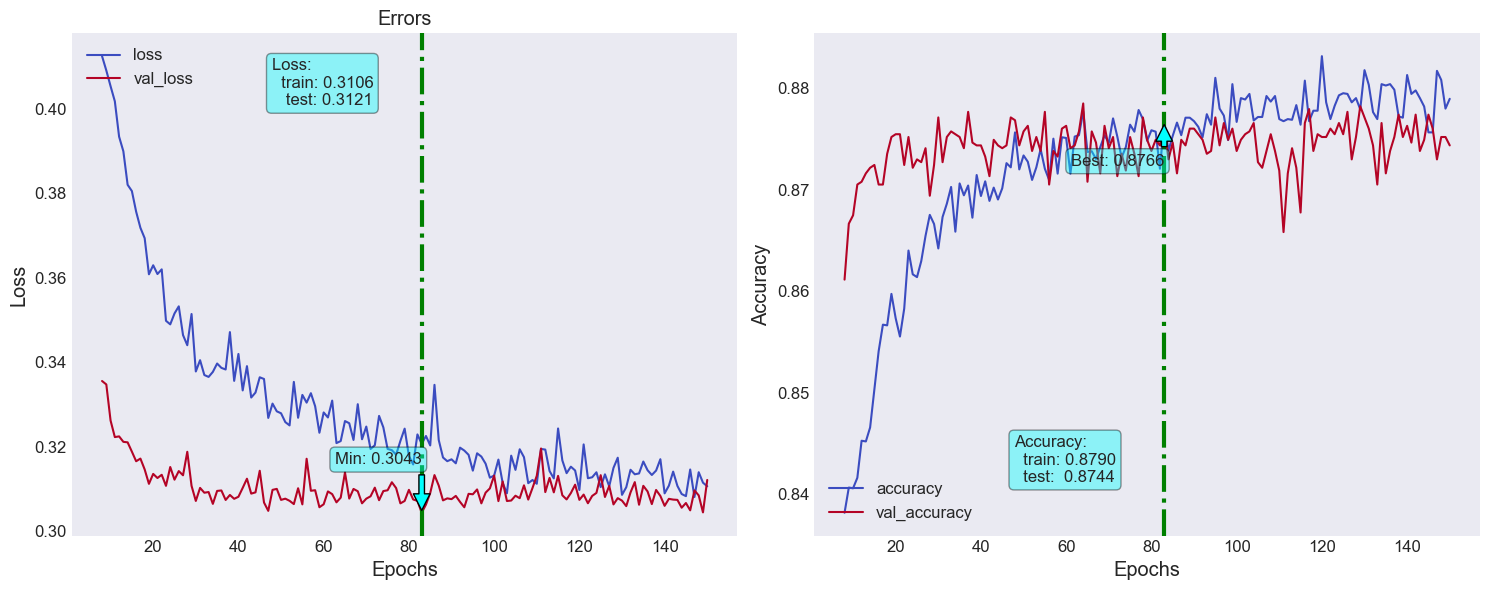

In [17]:
fn_plot_tf_hist(pd.DataFrame(history.history)[8:])

In [18]:
## Dropout rate constant 0.25 
## Results - train loss 0.4075
##           test loss 0.3316
##           min loss 0.3228 
##           test acc 0.8691
##           train acc 0.8357
##           best acc 0.8700
## The loss for test was lower than train hence drop out rate is lowered to 0.15

## results observed are good at 0.15 dropout rate as the difference in train and test loss is very low and the accuracy 
## is stabalized. But the training model starts learning after 40 epochs again and accuracy stabalizes around 80 epochs.
## Hence by adjusting batch size and no of epochs the model can start learning faster (completes leaning before 40 
## epochs or can learn steadily.)


#### dropout rate 0.35 0.25 0.15 0.05